In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# data = '/content/로트 데이터 이력.csv'
data = '/content/drive/MyDrive/반도체 프로젝트/로트 데이터 이력.csv'
df= pd.read_csv(data)
df

,S Lot,Post Thickness(A),dressing step sec,Etch Si RIE,Chamber,Etch test 적용 이력,CVD test 적용 이력
0,#1,4984,2,4670,A,test1,NaN
1,#2,5102,2,4689,B,test1,NaN
2,#3,5455,2,4695,C,test1,NaN
3,#4,5125,2,4721,A,test1,NaN
4,#5,5099,2,4652,B,test1,NaN
5,#6,5398,2,4822,C,NaN,test3
6,#7,5158,2,4788,A,NaN,test3
7,#8,5109,2,4762,B,NaN,test3
8,#9,5411,2,4785,C,NaN,test3
9,#10,4985,2,4785,A,NaN,test3


Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


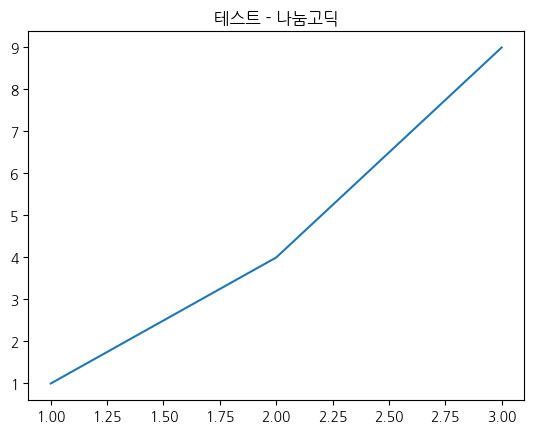

In [4]:
# 1) 폰트 설치
!apt-get -qq install fonts-nanum

# 2) 런타임에 폰트 캐시 리셋
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

# 폰트 경로 확인
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# Matplotlib에 폰트 등록
fm.fontManager.addfont(font_path)
mpl.rc('font', family='NanumGothic')

# 한글이 깨지지 않는지 테스트
plt.plot([1, 2, 3], [1, 4, 9])
plt.title("테스트 - 나눔고딕")
plt.show()

In [8]:
# CMP Post Target : 5000A +/- 400A
# Etch Post Target : 4800A +/-150A

# CMP 공정 후 박막 두께 데이터 분석

[CMP] 설계 시그마 (design σ) = 133.333

=== [CMP] 전체 LOT 기준 공정 능력 (설계 σ 기준) ===
Mean_sample = 5154.48, Sigma_sample = 180.84
Cp_design   = 1.000
Cpk_design  = 0.614

=== [CMP] 그룹별 Capability 요약 (설계 σ 기준) ===
         Group   N      Mean  Cp_design  Cpk_design
0          All  25  5154.480        1.0       0.614
1  Dressing 2s  12  5181.833        1.0       0.545
2  Dressing 4s  13  5129.231        1.0       0.677
3    Chamber A   9  5033.333        1.0       0.917
4    Chamber B   8  5053.875        1.0       0.865
5    Chamber C   8  5391.375        1.0       0.022


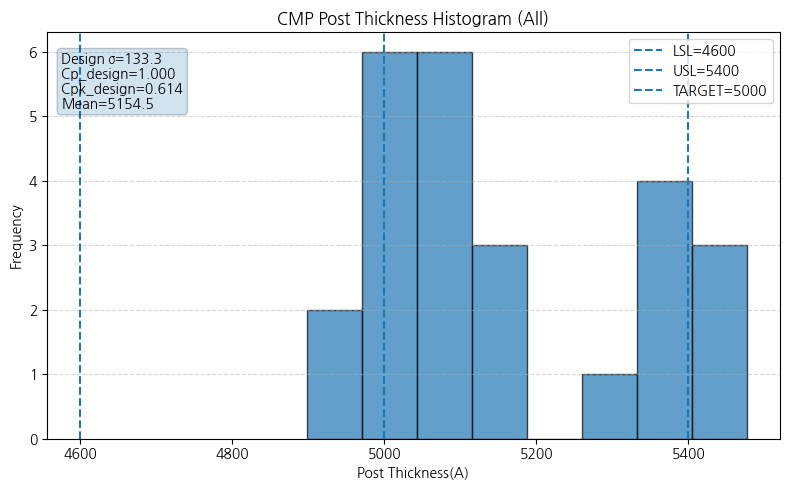

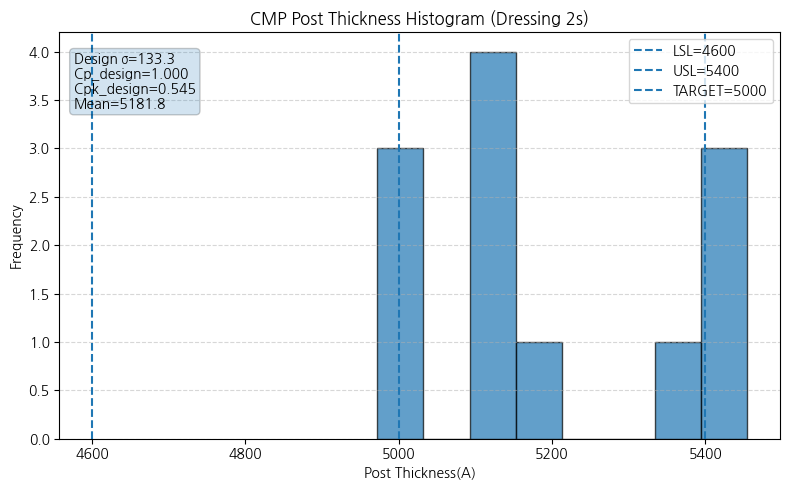

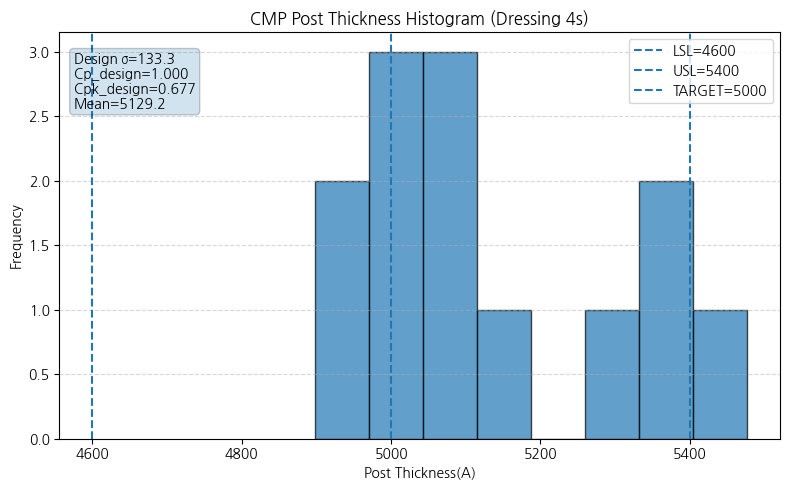

<Figure size 800x500 with 0 Axes>

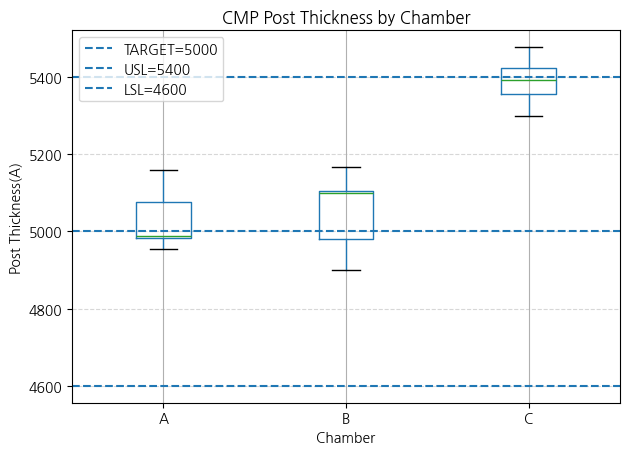

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 0. CMP 공정 Spec / 설계 시그마 설정 (CMP Post Thickness)
# ============================================================
# 기대 컬럼:
# ['S Lot', 'Post Thickness(A)', 'dressing step sec',
#  'Etch Si RIE', 'Chamber', 'Etch test 적용 이력', 'CVD test 적용 이력']

TARGET = 5000
LSL = 4600
USL = 5400

# 설계상 Spec = Target ± 400 = ±3σ 라고 가정
sigma_design = 400 / 3   # 역사적/설계상 시그마

print(f"[CMP] 설계 시그마 (design σ) = {sigma_design:.3f}")

# ============================================================
# 1. Capability 계산 함수 (설계 σ만 사용)
# ============================================================
def cpk_with_design_sigma(series, LSL, USL, sigma_design):
    """
    설계 시그마(고정)를 사용한 Cp, Cpk, mean 계산
    → mean shift 평가용
    """
    series = pd.Series(series).dropna()
    mean_val = series.mean()
    Cp = (USL - LSL) / (6 * sigma_design)  # 설계 Cp (여기선 1 근처)
    Cpu = (USL - mean_val) / (3 * sigma_design)
    Cpl = (mean_val - LSL) / (3 * sigma_design)
    Cpk = min(Cpu, Cpl)
    return Cp, Cpk, mean_val

def plot_hist_with_capability(series, title_suffix="All"):
    """히스토그램 + Spec + 설계 Cp/Cpk 텍스트"""
    series = pd.Series(series).dropna()
    Cp_d, Cpk_d, mean_d = cpk_with_design_sigma(series, LSL, USL, sigma_design)

    plt.figure(figsize=(8, 5))
    plt.hist(series, bins=8, edgecolor="black", alpha=0.7)

    plt.axvline(LSL, linestyle="--", label=f"LSL={LSL}")
    plt.axvline(USL, linestyle="--", label=f"USL={USL}")
    plt.axvline(TARGET, linestyle="--", label=f"TARGET={TARGET}")

    text_str = (
        f"Design σ={sigma_design:.1f}\n"
        f"Cp_design={Cp_d:.3f}\n"
        f"Cpk_design={Cpk_d:.3f}\n"
        f"Mean={mean_d:.1f}"
    )
    plt.text(0.02, 0.95, text_str, transform=plt.gca().transAxes,
             verticalalignment="top", fontsize=10,
             bbox=dict(boxstyle="round", alpha=0.2))

    plt.title(f"CMP Post Thickness Histogram ({title_suffix})")
    plt.xlabel("Post Thickness(A)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# ============================================================
# 2. 전체 LOT 기준 공정능력 (CMP)
# ============================================================
series_all = df["Post Thickness(A)"].astype(float)

Cp_design_all, Cpk_design_all, mean_all = cpk_with_design_sigma(
    series_all, LSL, USL, sigma_design
)
sigma_sample_all = series_all.std(ddof=1)  # 참고용

print("\n=== [CMP] 전체 LOT 기준 공정 능력 (설계 σ 기준) ===")
print(f"Mean_sample = {mean_all:.2f}, Sigma_sample = {sigma_sample_all:.2f}")
print(f"Cp_design   = {Cp_design_all:.3f}")
print(f"Cpk_design  = {Cpk_design_all:.3f}")

# ============================================================
# 3. 그룹별 Capability 테이블 (전체 / Dressing / Chamber)
# ============================================================
results = []

def append_group_result(name, sub_series):
    Cp_d, Cpk_d, mean_d = cpk_with_design_sigma(sub_series, LSL, USL, sigma_design)
    results.append({
        "Group": name,
        "N": len(sub_series),
        "Mean": round(mean_d, 3),
        "Cp_design": round(Cp_d, 3),
        "Cpk_design": round(Cpk_d, 3)
    })

# 전체
append_group_result("All", df["Post Thickness(A)"])

# Dressing step별
for step in sorted(df["dressing step sec"].unique()):
    sub = df[df["dressing step sec"] == step]["Post Thickness(A)"]
    append_group_result(f"Dressing {step}s", sub)

# Chamber 별
for ch in sorted(df["Chamber"].dropna().unique()):
    sub = df[df["Chamber"] == ch]["Post Thickness(A)"]
    append_group_result(f"Chamber {ch}", sub)

cpk_table = pd.DataFrame(results)

print("\n=== [CMP] 그룹별 Capability 요약 (설계 σ 기준) ===")
print(cpk_table)

# ============================================================
# 4. 히스토그램 (전체 + dressing step별)
# ============================================================
# 전체
plot_hist_with_capability(series_all, "All")

# dressing step 별
for step in sorted(df["dressing step sec"].unique()):
    sub = df[df["dressing step sec"] == step]["Post Thickness(A)"]
    plot_hist_with_capability(sub, f"Dressing {step}s")

# ============================================================
# 5. Chamber별 Boxplot + Spec 라인 (CMP)
# ============================================================
plt.figure(figsize=(8, 5))
df.boxplot(column="Post Thickness(A)", by="Chamber")

plt.axhline(TARGET, linestyle="--", label=f"TARGET={TARGET}")
plt.axhline(USL, linestyle="--", label=f"USL={USL}")
plt.axhline(LSL, linestyle="--", label=f"LSL={LSL}")

plt.title("CMP Post Thickness by Chamber")
plt.suptitle("")  # pandas boxplot 기본 제목 제거
plt.xlabel("Chamber")
plt.ylabel("Post Thickness(A)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Etch 공정 후 박막 두께 데이터 분석

[Etch] 설계 시그마 (design σ) = 50.000

=== [Etch] 전체 LOT 기준 공정 능력 (설계 σ 기준) ===
Mean_sample = 4798.16, Sigma_sample = 85.73
Cp_design   = 1.000
Cpk_design  = 0.988

=== [Etch] 그룹별 Capability 요약 (설계 σ 기준) ===
             Group   N      Mean  Cp_design  Cpk_design
0              All  25  4798.160        1.0       0.988
1  Etch test=test1   5  4685.400        1.0       0.236
2  Etch test=test2   5  4929.400        1.0       0.137
3        Chamber A   9  4796.778        1.0       0.979
4        Chamber B   8  4793.625        1.0       0.958
5        Chamber C   8  4804.250        1.0       0.972


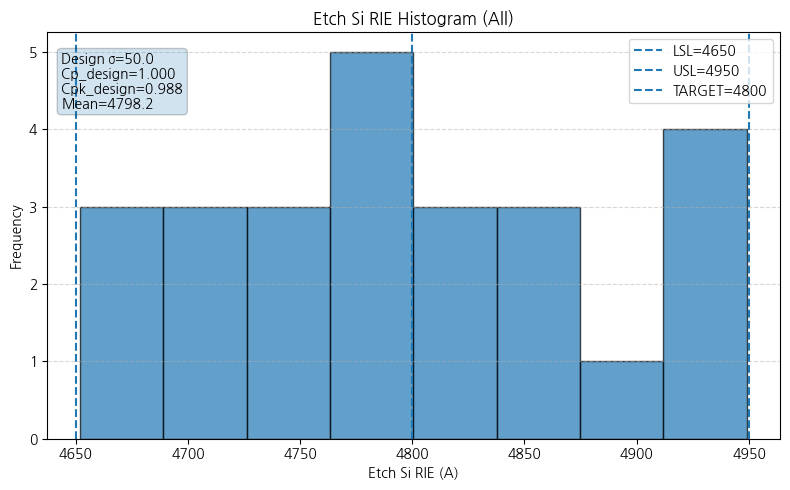

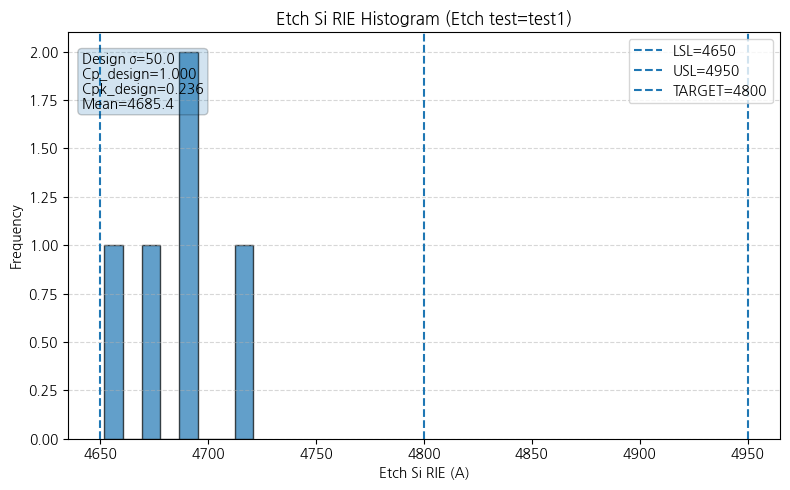

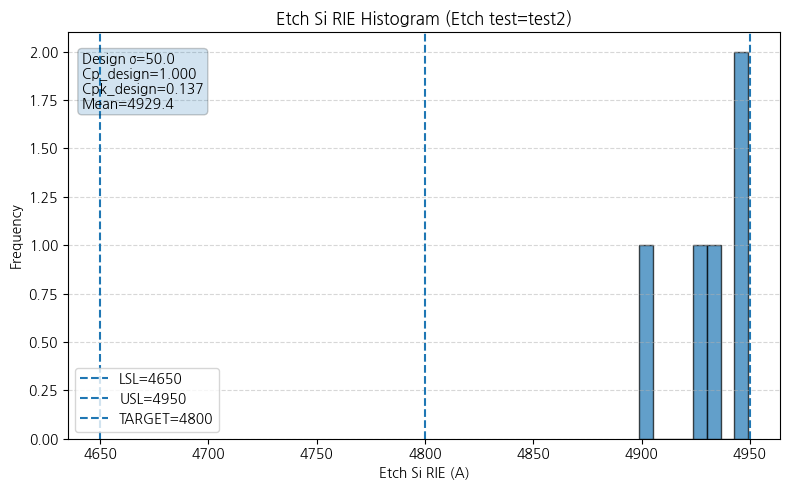

<Figure size 800x500 with 0 Axes>

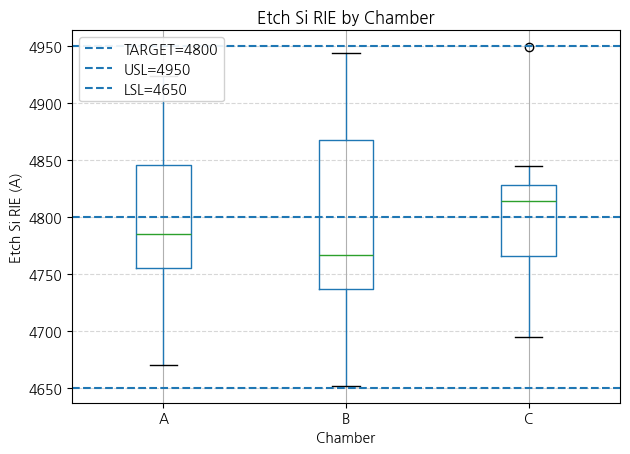

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 0. Etch 공정 Spec / 설계 시그마 설정 (Etch Si RIE)
# ============================================================
# Spec: 4800 ±150 → 3σ = 150
TARGET_ETCH = 4800
LSL_ETCH = 4650
USL_ETCH = 4950

sigma_design_etch = 150 / 3   # 설계 시그마

print(f"[Etch] 설계 시그마 (design σ) = {sigma_design_etch:.3f}")

# ============================================================
# 1. Capability 계산 함수 (Etch, 설계 σ만 사용)
# ============================================================
def cpk_with_design_sigma_etch(series, LSL, USL, sigma_design):
    """
    Etch: 설계 시그마(고정)를 사용한 Cp, Cpk, mean 계산
    → mean shift 평가용
    """
    series = pd.Series(series).dropna()
    mean_val = series.mean()
    Cp = (USL - LSL) / (6 * sigma_design)  # 설계 Cp (여기선 1 근처)
    Cpu = (USL - mean_val) / (3 * sigma_design)
    Cpl = (mean_val - LSL) / (3 * sigma_design)
    Cpk = min(Cpu, Cpl)
    return Cp, Cpk, mean_val

def plot_hist_with_capability_etch(series, title_suffix="All"):
    """Etch: 히스토그램 + Spec + 설계 Cp/Cpk 텍스트"""
    series = pd.Series(series).dropna()
    Cp_d, Cpk_d, mean_d = cpk_with_design_sigma_etch(
        series, LSL_ETCH, USL_ETCH, sigma_design_etch
    )

    plt.figure(figsize=(8, 5))
    plt.hist(series, bins=8, edgecolor="black", alpha=0.7)

    plt.axvline(LSL_ETCH, linestyle="--", label=f"LSL={LSL_ETCH}")
    plt.axvline(USL_ETCH, linestyle="--", label=f"USL={USL_ETCH}")
    plt.axvline(TARGET_ETCH, linestyle="--", label=f"TARGET={TARGET_ETCH}")

    text_str = (
        f"Design σ={sigma_design_etch:.1f}\n"
        f"Cp_design={Cp_d:.3f}\n"
        f"Cpk_design={Cpk_d:.3f}\n"
        f"Mean={mean_d:.1f}"
    )
    plt.text(0.02, 0.95, text_str, transform=plt.gca().transAxes,
             verticalalignment="top", fontsize=10,
             bbox=dict(boxstyle="round", alpha=0.2))

    plt.title(f"Etch Si RIE Histogram ({title_suffix})")
    plt.xlabel("Etch Si RIE (A)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# ============================================================
# 2. 전체 LOT 기준 Etch 공정능력
# ============================================================
series_etch_all = df["Etch Si RIE"].astype(float)

Cp_design_all_etch, Cpk_design_all_etch, mean_all_etch = cpk_with_design_sigma_etch(
    series_etch_all, LSL_ETCH, USL_ETCH, sigma_design_etch
)
sigma_sample_all_etch = series_etch_all.std(ddof=1)  # 참고용

print("\n=== [Etch] 전체 LOT 기준 공정 능력 (설계 σ 기준) ===")
print(f"Mean_sample = {mean_all_etch:.2f}, Sigma_sample = {sigma_sample_all_etch:.2f}")
print(f"Cp_design   = {Cp_design_all_etch:.3f}")
print(f"Cpk_design  = {Cpk_design_all_etch:.3f}")

# ============================================================
# 3. 그룹별 Capability 테이블 (Etch: 전체 / Etch test / Chamber)
# ============================================================
results_etch = []

def append_group_result_etch(name, sub_series):
    Cp_d, Cpk_d, mean_d = cpk_with_design_sigma_etch(
        sub_series, LSL_ETCH, USL_ETCH, sigma_design_etch
    )
    results_etch.append({
        "Group": name,
        "N": len(sub_series),
        "Mean": round(mean_d, 3),
        "Cp_design": round(Cp_d, 3),
        "Cpk_design": round(Cpk_d, 3)
    })

# 전체
append_group_result_etch("All", df["Etch Si RIE"])

# Etch test 적용 이력별
for test_name in sorted(df["Etch test 적용 이력"].dropna().unique()):
    sub = df[df["Etch test 적용 이력"] == test_name]["Etch Si RIE"]
    append_group_result_etch(f"Etch test={test_name}", sub)

# Chamber 별
for ch in sorted(df["Chamber"].dropna().unique()):
    sub = df[df["Chamber"] == ch]["Etch Si RIE"]
    append_group_result_etch(f"Chamber {ch}", sub)

cpk_table_etch = pd.DataFrame(results_etch)

print("\n=== [Etch] 그룹별 Capability 요약 (설계 σ 기준) ===")
print(cpk_table_etch)

# ============================================================
# 4. 히스토그램 (Etch 전체 + Etch test별)
# ============================================================
# 전체
plot_hist_with_capability_etch(series_etch_all, "All")

# Etch test별
for test_name in sorted(df["Etch test 적용 이력"].dropna().unique()):
    sub = df[df["Etch test 적용 이력"] == test_name]["Etch Si RIE"]
    plot_hist_with_capability_etch(sub, f"Etch test={test_name}")

# ============================================================
# 5. Etch Si RIE Boxplot (Chamber 기준) + Spec 라인
# ============================================================
plt.figure(figsize=(8, 5))
df.boxplot(column="Etch Si RIE", by="Chamber")

plt.axhline(TARGET_ETCH, linestyle="--", label=f"TARGET={TARGET_ETCH}")
plt.axhline(USL_ETCH, linestyle="--", label=f"USL={USL_ETCH}")
plt.axhline(LSL_ETCH, linestyle="--", label=f"LSL={LSL_ETCH}")

plt.title("Etch Si RIE by Chamber")
plt.suptitle("")  # pandas boxplot 기본 제목 제거
plt.xlabel("Chamber")
plt.ylabel("Etch Si RIE (A)")
plt.legend(loc='upper left', framealpha=0.9)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# 관리도

=== Design-based parameters ===
TARGET(CL) = 5000
LSL = 4600, USL = 5400
Design sigma = 133.333

=== MR-Chart parameters (data-based) ===
MR_bar = 248.04, UCL_MR = 810.35

=== Nelson 8 Rules 위반 (Wafer 번호 기준) ===
rule1: ['#3', '#9', '#21']
rule2: []
rule3: []
rule4: []
rule5: []
rule6: []
rule7: []
rule8: []
all_viol: ['#3', '#9', '#21']

=== Nelson 8 Rules 위반 Wafer 상세 ===
   S Lot  Post Thickness(A)  dressing step sec Chamber  Etch Si RIE  \
2     #3               5455                  2       C         4695   
8     #9               5411                  2       C         4785   
20   #21               5477                  4       C         4812   

   Etch test 적용 이력 CVD test 적용 이력  
2            test1            NaN  
8              NaN          test3  
20             NaN          test5  


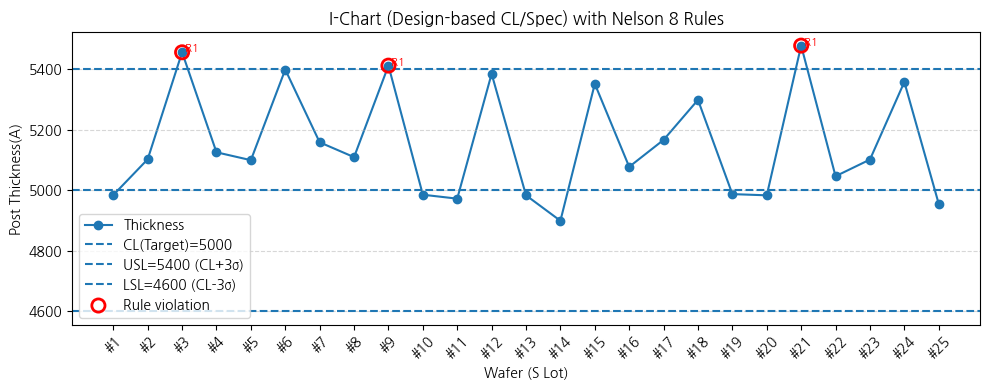

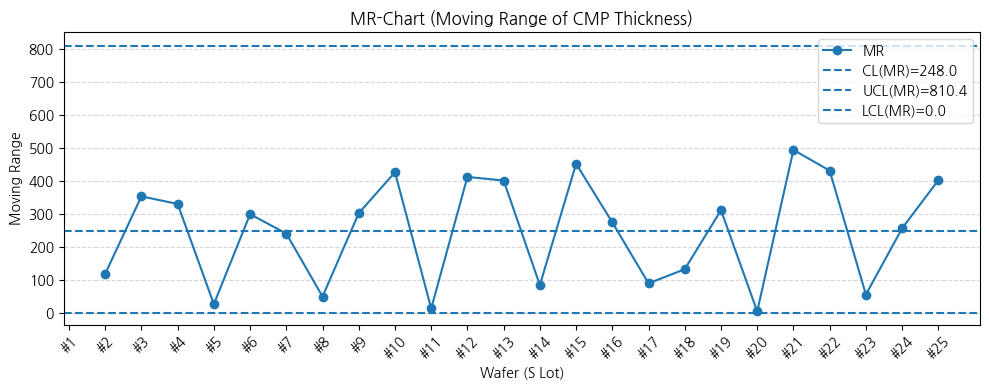

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. Spec / 디자인 정보 (CMP Post Thickness)
# ============================================================
TARGET = 5000      # 설계 타겟 (CL로 사용)
LSL = 4600         # Spec 하한 = Target - 400
USL = 5400         # Spec 상한 = Target + 400

# "±400이 3σ"라고 설계되었다고 가정 → 디자인 σ
sigma_design = 400 / 3

print("=== Design-based parameters ===")
print(f"TARGET(CL) = {TARGET}")
print(f"LSL = {LSL}, USL = {USL}")
print(f"Design sigma = {sigma_design:.3f}\n")

# ============================================================
# 2. I-MR용 데이터 준비 (시간순은 df 순서대로 가정)
# ============================================================
x_lot = df["S Lot"]
y_val = df["Post Thickness(A)"].astype(float)

# MR 계산 (참고용, Nelson 룰은 I-chart에만 적용)
MR = [np.nan]
for i in range(1, len(y_val)):
    MR.append(abs(y_val.iloc[i] - y_val.iloc[i-1]))
MR = pd.Series(MR, index=df.index)

MR_bar = MR[1:].mean()  # 첫 점 NaN 제외

# MR-chart 한계 (여기는 데이터 기반)
d3 = 0.0
d4 = 3.267
CL_MR = MR_bar
UCL_MR = d4 * MR_bar
LCL_MR = d3 * MR_bar    # = 0

print("=== MR-Chart parameters (data-based) ===")
print(f"MR_bar = {MR_bar:.2f}, UCL_MR = {UCL_MR:.2f}\n")

# ============================================================
# 3. Nelson 8 Rules (디자인 σ, 디자인 CL 기준)
# ============================================================
def detect_nelson_rules_I_chart(values, CL, sigma):
    """
    Nelson 8 Rules (I-chart, 디자인 CL/σ 기준)
      Rule 1: 한 점이 3σ 밖
      Rule 2: 9점 연속이 중심선의 한쪽에만 위치
      Rule 3: 6점 연속 증가 또는 6점 연속 감소
      Rule 4: 14점 연속이 상승/하강을 번갈아 반복
      Rule 5: 3점 중 2점 이상이 2σ 바깥(같은 쪽)
      Rule 6: 5점 중 4점 이상이 1σ 바깥(같은 쪽)
      Rule 7: 15점 연속이 모두 ±1σ 안쪽
      Rule 8: 8점 연속이 모두 ±1σ 바깥쪽
    """
    v = pd.Series(values).reset_index(drop=True)
    n = len(v)

    rules = {f"rule{i}": set() for i in range(1, 9)}

    upper3 = CL + 3*sigma
    lower3 = CL - 3*sigma
    upper2 = CL + 2*sigma
    lower2 = CL - 2*sigma
    upper1 = CL + 1*sigma
    lower1 = CL - 1*sigma

    # Rule 1: 1 point beyond 3σ
    for i in range(n):
        if v[i] > upper3 or v[i] < lower3:
            rules["rule1"].add(i)

    # Rule 2: 9 consecutive points on same side of CL
    for i in range(n - 8):
        w = v[i:i+9]
        if (w > CL).all() or (w < CL).all():
            rules["rule2"].update(w.index)

    # Rule 3: 6 consecutive points increasing or decreasing
    for i in range(n - 5):
        w = v[i:i+6]
        diff = np.diff(w.values)
        if np.all(diff > 0):
            rules["rule3"].update(w.index)
        elif np.all(diff < 0):
            rules["rule3"].update(w.index)

    # Rule 4: 14 consecutive points alternating up/down
    for i in range(n - 13):
        w = v[i:i+14]
        diff = np.diff(w.values)
        if np.any(diff == 0):
            continue
        sign = np.sign(diff)
        if np.all(sign[:-1] * sign[1:] == -1):
            rules["rule4"].update(w.index)

    # Rule 5: 2 of 3 successive points > 2σ from CL (same side)
    for i in range(n - 2):
        w = v[i:i+3]
        above = (w > upper2)
        below = (w < lower2)
        if above.sum() >= 2:
            rules["rule5"].update(w[above].index)
        if below.sum() >= 2:
            rules["rule5"].update(w[below].index)

    # Rule 6: 4 of 5 successive points > 1σ from CL (same side)
    for i in range(n - 4):
        w = v[i:i+5]
        above = (w > upper1)
        below = (w < lower1)
        if above.sum() >= 4:
            rules["rule6"].update(w[above].index)
        if below.sum() >= 4:
            rules["rule6"].update(w[below].index)

    # Rule 7: 15 consecutive points within ±1σ
    for i in range(n - 14):
        w = v[i:i+15]
        if ((w >= lower1) & (w <= upper1)).all():
            rules["rule7"].update(w.index)

    # Rule 8: 8 consecutive points outside ±1σ (either side)
    for i in range(n - 7):
        w = v[i:i+8]
        if ((w > upper1) | (w < lower1)).all():
            rules["rule8"].update(w.index)

    all_viol = set().union(*rules.values())
    rules["all"] = all_viol
    return rules

rule_results = detect_nelson_rules_I_chart(y_val, TARGET, sigma_design)

print("=== Nelson 8 Rules 위반 (Wafer 번호 기준) ===")
for i in range(1, 9):
    key = f"rule{i}"
    wafer_list = [df["S Lot"].iloc[idx] for idx in sorted(rule_results[key])]
    print(f"{key}: {wafer_list}")

all_wafer_list = [df["S Lot"].iloc[idx] for idx in sorted(rule_results["all"])]
print(f"all_viol: {all_wafer_list}")


if rule_results["all"]:
    viol_df = df.iloc[sorted(list(rule_results["all"]))][[
        "S Lot", "Post Thickness(A)", "dressing step sec",
        "Chamber", "Etch Si RIE", "Etch test 적용 이력", "CVD test 적용 이력"
    ]]
    print("\n=== Nelson 8 Rules 위반 Wafer 상세 ===")
    print(viol_df)

# ============================================================
# 4. I-Chart (디자인 CL/Spec 기반, Nelson 위반점 표시)
# ============================================================
plt.figure(figsize=(10, 4))
plt.plot(x_lot, y_val, marker="o", label="Thickness", zorder=1)

# 디자인 기준 CL과 3σ 한계(= Spec)
plt.axhline(TARGET, linestyle="--", label=f"CL(Target)={TARGET}")
plt.axhline(USL, linestyle="--", label=f"USL={USL} (CL+3σ)")
plt.axhline(LSL, linestyle="--", label=f"LSL={LSL} (CL-3σ)")

# Nelson 룰 위반점
viol_idx = sorted(list(rule_results["all"]))
if viol_idx:
    plt.scatter(x_lot.iloc[viol_idx], y_val.iloc[viol_idx],
                s=90, facecolor="none", edgecolor="red",
                marker="o", linewidths=2, label="Rule violation", zorder=2)
    # 어떤 룰에 걸렸는지 태그
    for i in viol_idx:
        tags = []
        for r in range(1, 9):
            if i in rule_results[f"rule{r}"]:
                tags.append(f"R{r}")
        tag_str = ",".join(tags)
        plt.text(x_lot.iloc[i], y_val.iloc[i], f" {tag_str}", color="red", fontsize=8)

plt.title("I-Chart (Design-based CL/Spec) with Nelson 8 Rules")
plt.xlabel("Wafer (S Lot)")
plt.ylabel("Post Thickness(A)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ============================================================
# 5. MR-Chart (참고용, 데이터 기반)
# ============================================================
plt.figure(figsize=(10, 4))
plt.plot(x_lot, MR, marker="o", label="MR")

plt.axhline(CL_MR, linestyle="--", label=f"CL(MR)={CL_MR:.1f}")
plt.axhline(UCL_MR, linestyle="--", label=f"UCL(MR)={UCL_MR:.1f}")
plt.axhline(LCL_MR, linestyle="--", label=f"LCL(MR)={LCL_MR:.1f}")

plt.title("MR-Chart (Moving Range of CMP Thickness)")
plt.xlabel("Wafer (S Lot)")
plt.ylabel("Moving Range")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Etch 테스트 효과 분석

<Figure size 800x500 with 0 Axes>

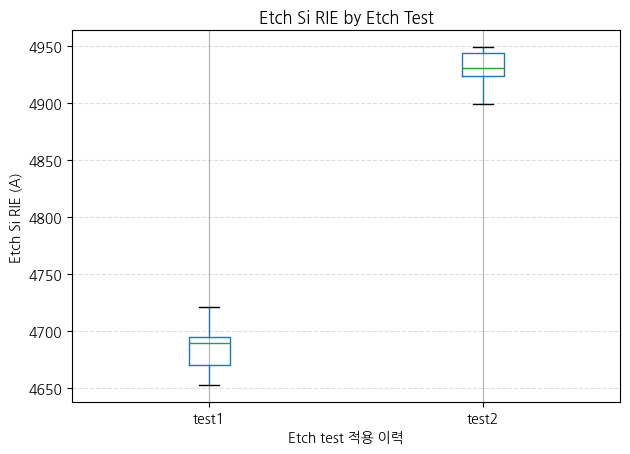


=== 단일표본 t-검정 (검정 대상: 평균 = 4800?) ===

--- Test=test1 ---
n=5, mean=4685.400, std=26.102
t=-9.817, p=0.00060
→ 평균이 4800과 **유의하게 다르다 (mean shift 있음)**

--- Test=test2 ---
n=5, mean=4929.400, std=19.705
t=14.684, p=0.00013
→ 평균이 4800과 **유의하게 다르다 (mean shift 있음)**



In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

# -----------------------------------------------
# 기준값
TARGET_ETCH = 4800
# -----------------------------------------------

# NaN 제거
df_etch = df.dropna(subset=["Etch Si RIE", "Etch test 적용 이력"]).copy()

# -----------------------------------------------
# 1) Etch test별 박스플롯
# -----------------------------------------------
plt.figure(figsize=(8,5))
df_etch.boxplot(column="Etch Si RIE", by="Etch test 적용 이력")

# plt.axhline(TARGET_ETCH, linestyle="--", color="orange")
# plt.text(0.5, TARGET_ETCH + 2, "TARGET=4800", color="orange")

plt.title("Etch Si RIE by Etch Test")
plt.suptitle("")
plt.ylabel("Etch Si RIE (A)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 2) Etch Test별 단일표본 t-test (4800 기준)
# -----------------------------------------------
tests = sorted(df_etch["Etch test 적용 이력"].unique())
print("\n=== 단일표본 t-검정 (검정 대상: 평균 = 4800?) ===\n")

for tname in tests:
    x = df_etch.loc[df_etch["Etch test 적용 이력"] == tname, "Etch Si RIE"].astype(float)

    # 단일표본 t-test (μ = 4800)
    t_stat, p_val = ttest_1samp(x, TARGET_ETCH)

    print(f"--- Test={tname} ---")
    print(f"n={len(x)}, mean={x.mean():.3f}, std={x.std(ddof=1):.3f}")
    print(f"t={t_stat:.3f}, p={p_val:.5f}")

    if p_val < 0.05:
        print("→ 평균이 4800과 **유의하게 다르다 (mean shift 있음)**\n")
    else:
        print("→ 평균이 4800과 **유의하게 다르지 않다 (mean shift 없음)**\n")


#  CVD 이력 분석

/tmp/ipython-input-1925356373.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Chamber", y="Post Thickness(A)", data=cvd_df, order=chamber_order, palette="Set2")
/tmp/ipython-input-1925356373.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x="Chamber", y="Post Thickness(A)", data=cvd_df, order=chamber_order,
/tmp/ipython-input-1925356373.py:28: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x="Chamber", y="Post Thickness(A)", data=cvd_df, order=chamber_order,


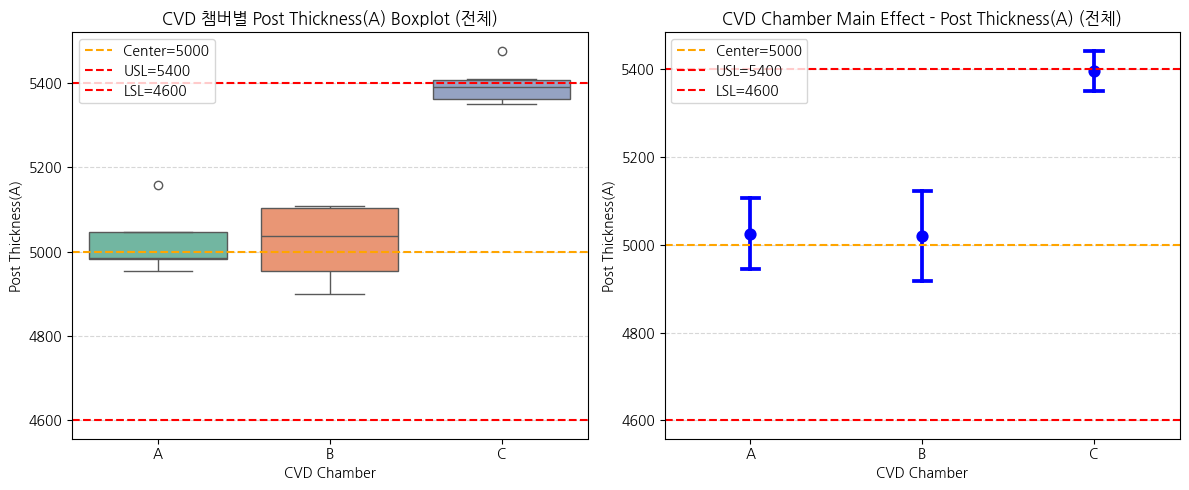

/tmp/ipython-input-1925356373.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Chamber", y="Post Thickness(A)", data=group, order=chamber_order, palette="Set2")
/tmp/ipython-input-1925356373.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x="Chamber", y="Post Thickness(A)", data=group, order=chamber_order,
/tmp/ipython-input-1925356373.py:61: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x="Chamber", y="Post Thickness(A)", data=group, order=chamber_order,


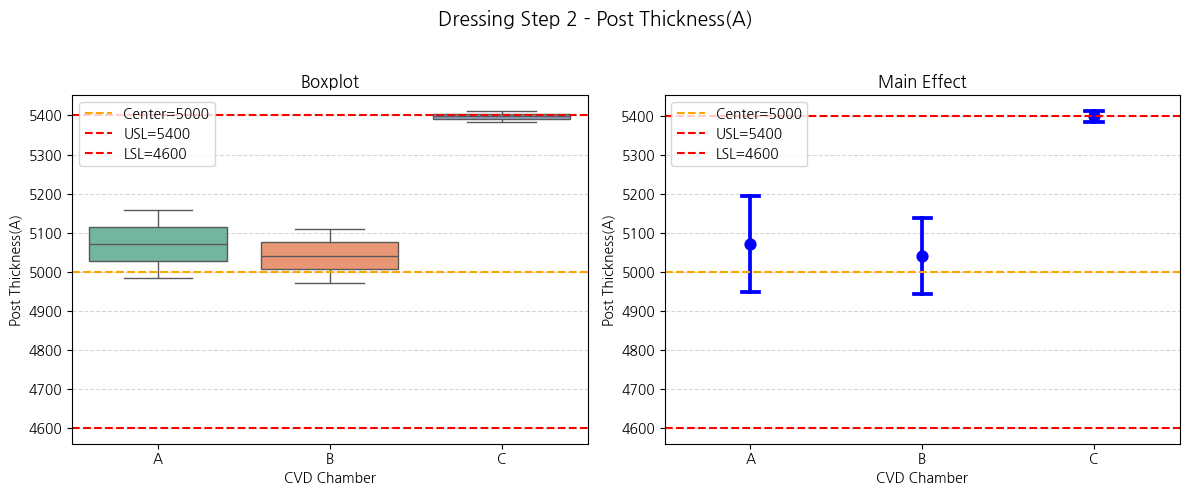

/tmp/ipython-input-1925356373.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Chamber", y="Post Thickness(A)", data=group, order=chamber_order, palette="Set2")
/tmp/ipython-input-1925356373.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x="Chamber", y="Post Thickness(A)", data=group, order=chamber_order,
/tmp/ipython-input-1925356373.py:61: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x="Chamber", y="Post Thickness(A)", data=group, order=chamber_order,


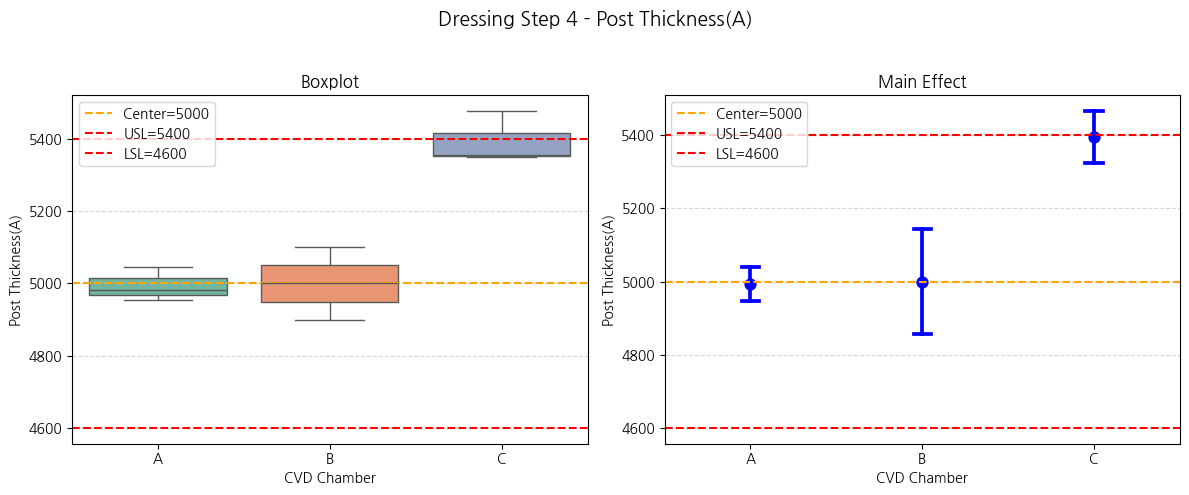

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# CVD 적용된 데이터만 선택
cvd_df = df.dropna(subset=["CVD test 적용 이력"])

# 챔버 순서 지정
chamber_order = ["A", "B", "C"]

# -------------------- 전체 Boxplot + Main Effect --------------------
plt.figure(figsize=(12,5))

# Boxplot
plt.subplot(1,2,1)
sns.boxplot(x="Chamber", y="Post Thickness(A)", data=cvd_df, order=chamber_order, palette="Set2")
plt.axhline(5000, color='orange', linestyle='--', label='Center=5000')
plt.axhline(5400, color='red', linestyle='--', label='USL=5400')
plt.axhline(4600, color='red', linestyle='--', label='LSL=4600')
plt.title("CVD 챔버별 Post Thickness(A) Boxplot (전체)")
plt.xlabel("CVD Chamber")
plt.ylabel("Post Thickness(A)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Main Effect Plot
plt.subplot(1,2,2)
sns.pointplot(x="Chamber", y="Post Thickness(A)", data=cvd_df, order=chamber_order,
              ci='sd', join=False, capsize=0.1, color='blue')
plt.axhline(5000, color='orange', linestyle='--', label='Center=5000')
plt.axhline(5400, color='red', linestyle='--', label='USL=5400')
plt.axhline(4600, color='red', linestyle='--', label='LSL=4600')
plt.title("CVD Chamber Main Effect - Post Thickness(A) (전체)")
plt.xlabel("CVD Chamber")
plt.ylabel("Post Thickness(A)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# -------------------- CMP Step별 Boxplot --------------------
for step, group in cvd_df.groupby("dressing step sec"):
    plt.figure(figsize=(12,5))
    plt.suptitle(f"Dressing Step {step} - Post Thickness(A)", fontsize=14)

    # Boxplot
    plt.subplot(1,2,1)
    sns.boxplot(x="Chamber", y="Post Thickness(A)", data=group, order=chamber_order, palette="Set2")
    plt.axhline(5000, color='orange', linestyle='--', label='Center=5000')
    plt.axhline(5400, color='red', linestyle='--', label='USL=5400')
    plt.axhline(4600, color='red', linestyle='--', label='LSL=4600')
    plt.title("Boxplot")
    plt.xlabel("CVD Chamber")
    plt.ylabel("Post Thickness(A)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Main Effect
    plt.subplot(1,2,2)
    sns.pointplot(x="Chamber", y="Post Thickness(A)", data=group, order=chamber_order,
                  ci='sd', join=False, capsize=0.1, color='blue')
    plt.axhline(5000, color='orange', linestyle='--', label='Center=5000')
    plt.axhline(5400, color='red', linestyle='--', label='USL=5400')
    plt.axhline(4600, color='red', linestyle='--', label='LSL=4600')
    plt.title("Main Effect")
    plt.xlabel("CVD Chamber")
    plt.ylabel("Post Thickness(A)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

